In [1]:
import argparse
from copy import deepcopy
import logging
import random
from collections import defaultdict
from os.path import join
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import joblib
import imodels
import inspect
import os.path
import imodelsx.cache_save_utils
import sys
import torch
#path_to_repo = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

#os.chdir(path_to_repo)
#os.chdir('/home/mattyshen/interpretableDistillation')
sys.path.append('..')

import idistill.model
import idistill.data
from idistill.ftd import FTDistillRegressorCV
from idistill.whitebox_figs import FIGSRegressor, FIGSClassifier
from idistill.subset_predictors import L0L2RegressorCV

sys.path.append('/home/mattyshen/iCBM')

from CUB.template_model import End2EndModel, Inception3, MLP

class ARGS:
    def __init__(self, a_dict):
        for k in a_dict.keys():
            exec(f'self.{k} = a_dict["{k}"]')
            
def fit_model(model, X_train, y_train, feature_names, r):
    # fit the model
    fit_parameters = inspect.signature(model.fit).parameters.keys()
    if "feature_names" in fit_parameters and feature_names is not None:
        model.fit(X_train, y_train, feature_names=feature_names)
    else:
        model.fit(X_train, y_train)

    return r, model

def evaluate_model(model, X_train, X_val, y_train, y_val, comp, seed, r):
    """Evaluate model performance on each split"""
    metrics = {
            "accuracy": accuracy_score,
        }
    for split_name, (X_, y_) in zip(
        ["trainval", "test"], [(X_train, y_train), (X_val, y_val)]
    ):
        y_pred_ = model.predict(X_)
        if len(y_pred_.shape) > 1 and y_pred_.shape[1] > 1:
            #handle regressors
            y_pred_ = np.argmax(y_pred_, axis=1)
        for i, (metric_name, metric_fn) in enumerate(metrics.items()):
            print(metric_fn(y_, y_pred_))
            r[f"{comp}_seed{seed}_{metric_name}_{split_name}"] = metric_fn(y_, y_pred_)

    return r

def load_csvs(path):

    X_train = pd.read_csv(f'{path}/X_trainval.csv', index_col=0)
    X_train_hat = pd.read_csv(f'{path}/X_trainval_hat.csv', index_col=0)
    X_test = pd.read_csv(f'{path}/X_test.csv', index_col=0)
    X_test_hat = pd.read_csv(f'{path}/X_test_hat.csv', index_col=0)
    y_train = pd.read_csv(f'{path}/y_trainval.csv', index_col=0)
    y_train_hat = pd.read_csv(f'{path}/y_trainval_hat.csv', index_col=0)
    y_test = pd.read_csv(f'{path}/y_test.csv', index_col=0)
    y_test_hat = pd.read_csv(f'{path}/y_test_hat.csv', index_col=0)

    return X_train, X_train_hat, X_test, X_test_hat, y_train, y_train_hat, y_test, y_test_hat

def find_optimal_threshold(y_true, y_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

def find_thresh(linkage_matrix, min_clusters=10, max_clusters=15, step=0.1, count = 0):
    if count > 3:
        print(max_clusters)
        return find_thresh(linkage_matrix, min_clusters=min_clusters, max_clusters=(max_clusters-5*4)-1, step=step, count = 0)
    threshold = 4.9
    while threshold < 10:
        clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
        num_clusters = len(set(clusters))
        if min_clusters <= num_clusters <= max_clusters:
            return threshold, num_clusters
        threshold += step
    print('find_thresh recursive call beginning')
    return find_thresh(linkage_matrix, min_clusters=min_clusters, max_clusters=max_clusters+5, step=0.1, count = count+1)
    #return None, 0

def cluster_concepts(X, num_clusters):
    distance_matrix = 1 - X_train_hat.corr().abs()
    linkage_matrix = linkage(squareform(distance_matrix), method='ward')
    
    threshold, _ = find_thresh(linkage_matrix, min_clusters=num_clusters-5, max_clusters=num_clusters, step=0.1)
        
    clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
    
    feature_groups = {}
    for i, cluster_id in enumerate(clusters):
        feature_groups.setdefault(cluster_id, []).append(distance_matrix.columns[i])
    
    return feature_groups

def process_X(X_train, X_train_hat, X_test, X_test_hat, prepro, num_clusters, thresh=0):
    if prepro == "probs":
        return X_train_hat, X_test_hat, None
    elif prepro == 'cluster':
        f_gs = cluster_concepts(X_train_hat, num_clusters)
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    elif prepro == 'global':
        f_gs = cluster_concepts(X_train_hat, num_clusters)
        opt_thresh = find_optimal_threshold(X_train.values.reshape(-1, ), X_train_hat.values.reshape(-1, ))
        
        return (X_train_hat > opt_thresh).astype(int), (X_test_hat > opt_thresh).astype(int), f_gs
    elif prepro == 'gpt1':
        f_gs = {1:['c'+str(i) for i in range(1, 5)]+['c'+str(i) for i in range(53, 55)]+['c'+str(i) for i in range(100, 104)],
                2:['c'+str(i) for i in range(5, 11)]+['c'+str(i) for i in range(110, 113)]+['c78'],
                3:['c'+str(i) for i in range(11, 17)]+['c'+str(i) for i in range(26, 32)]+['c'+str(i) for i in range(85, 88)]+['c'+str(i) for i in range(65, 71)]+['c'+str(i) for i in range(104, 110)],
                4:['c'+str(i) for i in range(17, 24)]+['c'+str(i) for i in range(40, 51)]+['c'+str(i) for i in range(24, 26)]+['c'+str(i) for i in range(71, 78)]+['c'+str(i) for i in range(60, 65)],
                5:['c'+str(i) for i in range(32, 38)]+['c'+str(i) for i in range(88, 91)],
                6:['c38', 'c39', 'c51','c52']+['c'+str(i) for i in range(55, 60)],
                7:['c'+str(i) for i in range(97, 100)],
                8:['c'+str(i) for i in range(91, 97)]+['c'+str(i) for i in range(79, 85)]
        }
        
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    elif prepro == 'gpt2':
        f_gs = {1:['c'+str(i) for i in range(1, 5)]+['c'+str(i) for i in range(53, 55)]+['c32']+['c'+str(i) for i in range(78, 85)],
                2:['c'+str(i) for i in range(5, 11)]+['c'+str(i) for i in range(110, 113)]+['c'+str(i) for i in range(33, 38)]+['c'+str(i) for i in range(88, 91)],
                3:['c'+str(i) for i in range(91, 97)]+['c'+str(i) for i in range(11, 17)]+['c'+str(i) for i in range(26, 32)]+['c'+str(i) for i in range(85, 88)]+['c'+str(i) for i in range(17, 24)]+['c'+str(i) for i in range(60, 65)],
                4:['c'+str(i) for i in range(40, 51)]+['c24', 'c25']+['c'+str(i) for i in range(104, 110)]+['c'+str(i) for i in range(55, 60)]+['c'+str(i) for i in range(65, 78)],
                5:['c38', 'c39', 'c51','c52'],
                6:['c'+str(i) for i in range(100, 104)]+['c'+str(i) for i in range(97, 100)]
        }
        
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    elif prepro == 'gpt3':
        f_gs = {1:['c'+str(i) for i in range(1, 5)]+['c53', 'c54']+['c'+str(i) for i in range(100, 104)],
                2:['c78', 'c32']+['c'+str(i) for i in range(5, 11)]+['c'+str(i) for i in range(110, 113)]+['c'+str(i) for i in range(88, 91)]+['c'+str(i) for i in range(33, 38)],
                3:['c'+str(i) for i in range(91, 97)]+['c'+str(i) for i in range(11, 24)]+['c'+str(i) for i in range(26, 32)]+['c'+str(i) for i in range(85, 88)]+['c'+str(i) for i in range(55, 78)]+['c'+str(i) for i in range(104, 110)],
                4:['c'+str(i) for i in range(40, 51)]+['c24', 'c25', 'c38', 'c39', 'c51', 'c52'],
                5:['c'+str(i) for i in range(79, 85)],
                6:['c'+str(i) for i in range(97, 100)]
        }
        
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    
    elif prepro == 'gpt4':
        f_gs = {1:[1,3,5,7,8,11,12,15,16,19,20,21,22,24,26,27,40,41,42,43,46,49,50,53,55,56,60,62,64,65,66,69,70,71,72,77,78,79,80,83,84,85,87,88,90,91,92,93,94,95,102,106,107,108,110],
                2:[4,6,10,13,14,17,18,23,25,29,54,73,76,86,89,97,98,104,105,111],
                3:[2,9,28,30,32,33,34,35,36,37,38,39,47,48,51,52,81,96,99],
                4:[31,44,45,57,58,59,61,63,67,68,74,75,82,100,101,103,109,112]
        }
        
        for k in f_gs.keys():
            f_gs[k] = ['c'+str(i) for i in f_gs[k]]
        
        optimal_thresholds = np.zeros(X_train.shape[1])
        
        for k in f_gs.keys():
            idxs = [int(s[1:]) - 1 for s in f_gs[k]]
            optimal_thresholds[idxs] = find_optimal_threshold(X_train[f_gs[k]].values.reshape(-1, ), X_train_hat[f_gs[k]].values.reshape(-1, ))

        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
        
    elif prepro == 'binary' and thresh > 0:
        f_gs = cluster_concepts(X_train_hat, num_clusters)
        return (X_train_hat > thresh).astype(int), (X_test_hat > thresh).astype(int), f_gs
    else:
        f_gs = cluster_concepts(X_train_hat, num_clusters)
        optimal_thresholds = []
        for class_idx in range(X_train_hat.shape[1]):
            y_true_class = X_train.iloc[:, class_idx]
            y_probs_class = X_train_hat.iloc[:, class_idx]
            optimal_thresholds.append(find_optimal_threshold(y_true_class, y_probs_class))
        optimal_thresholds = np.array(optimal_thresholds)
        
        return (X_train_hat > optimal_thresholds).astype(int), (X_test_hat > optimal_thresholds).astype(int), f_gs
    
def process_y(y_train, y_train_hat, y_test, y_test_hat, prepro):
    if prepro == "probs":
        return softmax(y_train_hat, axis=1), softmax(y_test_hat, axis=1)
    elif prepro == "classes":
        return pd.DataFrame(y_train_hat.idxmax(axis=1).astype(int)), pd.DataFrame(y_test_hat.idxmax(axis=1).astype(int))
    else:
        return y_train_hat, y_test_hat

/home/mattyshen/anaconda3/lib/python3.9/site-packages/aiohttp/helpers.py:107: DeprecationWarning: "@coroutine" decorator is deprecated since Python 3.8, use "async def" instead
  def noop(*args, **kwargs):  # type: ignore
2025-01-26 13:25:52.787406: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-26 13:25:53.730891: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mattyshen/anaconda3/lib/python3.9/site-packages/botocore/httpsession.py:34: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as

In [2]:
f_gs = {1:[1,3,5,7,8,11,12,15,16,19,20,21,22,24,26,27,40,41,42,43,46,49,50,53,55,56,60,62,64,65,66,69,70,71,72,77,78,79,80,83,84,85,87,88,90,91,92,93,94,95,102,106,107,108,110],
                2:[4,6,10,13,14,17,18,23,25,29,54,73,76,86,89,97,98,104,105,111],
                3:[2,9,28,30,32,33,34,35,36,37,38,39,47,48,51,52,81,96,99],
                4:[31,44,45,57,58,59,61,63,67,68,74,75,82,100,101,103,109,112]
        }

[len(f_gs[i])for i in f_gs.keys()]

[55, 20, 19, 18]

In [3]:
def extract_interactions(model):
    """
    Extracts all feature interactions from the FIGS model by parsing through each additive tree.

    Parameters:
        model: A FIGS model containing an attribute `trees_`.
               Each tree is comprised of hierarchically linked `Node` objects.

    Returns:
        interactions: A list of sets, where each set contains the features involved in an interaction.
    """
    interactions = []

    def traverse_tree(node, current_features, current_depth):
        """
        Recursively traverse a tree to collect feature interactions.

        Parameters:
            node: The current `Node` object in the tree.
            current_features: A set of features encountered so far in the current path.
        """
        if node.left is None and node.right is None:
            pos_idx = node.value > 0
            neg_idx = node.value <= 0
            cur_interactions.append((current_features, np.var(node.value[pos_idx])+np.var(node.value[neg_idx])))
            return

        # Add the current feature to the set of features for this path

        # If the node has children, traverse them
        if node.left is not None:
            current_features_l = current_features.copy()
            current_features_l.append('c' + str(node.feature+1))
            traverse_tree(node.left, current_features_l.copy(), current_depth=current_depth+1)
        if node.right is not None:
            current_features_r = current_features.copy()
            current_features_r.append('!c' + str(node.feature+1))
            traverse_tree(node.right, current_features_r.copy(), current_depth=current_depth+1)

    # Loop through each tree in the model
    # traverse_tree(model.trees_[0], set(), current_depth=0)
    # return interactions
    for tree in model.trees_:
        # Start traversal for each tree
        cur_interactions = []
        traverse_tree(tree, [], current_depth=0)
        interactions.append(cur_interactions)
    return interactions

In [4]:
args_dict = {}
args_dict['task_type'] = 'regression'
args_dict['model_name'] = 'FIGSRegressor'
args_dict['X_type'] = 'binary'
args_dict['thresh'] = 0.45
args_dict['Y_type'] = 'logits'
args_dict['max_rules'] = 100
args_dict['max_trees'] = 20
args_dict['max_depth'] = 4
args_dict['device'] = 'cuda:0'
args_dict['num_clusters'] = 5
args_dict['num_bootstraps'] = 2

args = ARGS(args_dict)
r = {}

In [5]:
X_train, X_train_hat, X_test, X_test_hat, y_train, y_train_hat, y_test, y_test_hat = load_csvs(f'/home/mattyshen/DistillationEdit/data/cub_tabular/seed0_Joint0.01SigmoidModel__Seed1')
X_train_model, X_test_model, clusters = process_X(X_train, X_train_hat, X_test, X_test_hat, args.X_type, args.num_clusters, args.thresh)
y_train_model, y_test_model = process_y(y_train, y_train_hat, y_test, y_test_hat, args.Y_type)

In [6]:
model = FIGSRegressor(max_rules = args.max_rules, max_trees = args.max_trees, max_depth = args.max_depth)
r, model = fit_model(model, X_train_model, y_train_model, None, r)

In [10]:
figs_test_preds.shape

(5794, 200)

In [56]:
figs_test_preds = model.predict(X_test_model, by_tree = True)

mask = np.abs(figs_test_preds) > 0.01

accuracy_score(np.argmax(np.sum(np.multiply(mask, figs_test_preds), axis = 2),axis = 1), y_test)

0.7664825681739731

In [68]:
masked = mask*figs_test_preds

In [69]:
t = [np.sum((masked)[i, i, :] != 0) for i in np.argmax(np.sum(np.multiply(mask, figs_test_preds), axis = 2),axis = 1)]

In [72]:
np.unique(t)

array([16, 17, 18, 19, 20])

In [91]:
t = pd.concat([X_train, y_train], axis = 1)
t.columns = ['c' + str(i) for i in range(1, 113)] + ['class']
classes = t.groupby('class').first()

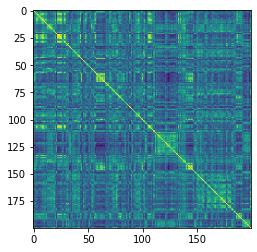

In [93]:
import matplotlib.pyplot as plt


plt.imshow(classes.T.corr())

In [14]:
accuracy_score(np.argmax(model.predict(X_test_model), axis = 1), y_test)

0.7666551605108733

In [9]:
cur_interactions = extract_interactions(model)

In [10]:
flat_list = [ x for xs in cur_interactions for x in xs ]

In [11]:
test_pred_intervention = model.predict(X_test_model, by_tree = True)

In [12]:
def get_argmax_max(variances, index):
    maxes = np.partition(variances, -2, axis=1)[:, -index]
    argmaxes = np.argsort(variances, axis=1)[:, -index]
    return maxes, argmaxes

In [13]:
test_pred_intervention[0, :, :][test_pred_intervention[0, :, :] > 0].shape

(1930,)

In [14]:
store = np.zeros((test_pred_intervention.shape[0], test_pred_intervention.shape[2]))

for i in range(test_pred_intervention.shape[0]):
    for j in range(test_pred_intervention[i, :, :].shape[1]):
        pos_idx = test_pred_intervention[i, :, j] > 0
        neg_idx = test_pred_intervention[i, :, j] <= 0
        test_pred_intervention[i, :, j]
        store[i, j] = np.var(test_pred_intervention[i, :, j][pos_idx])+np.var(test_pred_intervention[i, :, j][neg_idx])
store

NameError: name 'i' is not defined

In [ ]:
# Compute masks for positive and negative elements across all slices at once
pos_mask = test_pred_intervention > 0
neg_mask = ~pos_mask  # Equivalent to test_pred_intervention <= 0

# Calculate variances for positive and negative values
pos_var = np.var(test_pred_intervention * pos_mask, axis=1, where=pos_mask, ddof=0)
neg_var = np.var(test_pred_intervention * neg_mask, axis=1, where=neg_mask, ddof=0)

# Sum the variances for positive and negative values along the required axis
store = pos_var + neg_var


In [ ]:
store.shape, np.var(np.abs(test_pred_intervention), axis = 1).shape

In [ ]:
def extract_adaptive_intervention(model, X, number_of_top_paths, tol = 0.0001):
    #test_pred_intervention = model.predict(X, by_tree = True)

    concepts_to_edit = [[] for _ in range(X.shape[0])]
    variances = store

    for idx in range(number_of_top_paths):
        maxes, argmaxes = get_argmax_max(variances, idx+1)
        for i, (tree_idx, var) in enumerate(zip(argmaxes, maxes)):
            for paths in cur_interactions[tree_idx]:
                if abs(paths[1] - var) < tol:
                    concept_indexes = [int(p[1:])-1 if p[0] != '!' else int(p[2:])-1 for p in paths[0]]
                    concepts_to_edit[i].append(concept_indexes)
                    
    concepts_to_edit = [sum(element, []) for element in concepts_to_edit]
    concepts_to_edit = [list(set(c)) for c in concepts_to_edit]
    
    return concepts_to_edit

In [ ]:
concepts_to_edit = extract_adaptive_intervention(model, X_test_model, 3)

In [ ]:
for i in range(len(concepts_to_edit)):
    X_test_model.iloc[i, concepts_to_edit[i]] = X_test.iloc[i, concepts_to_edit[i]]

In [ ]:
accuracy_score(np.argmax(model.predict(X_test_model), axis = 1), y_test)

In [ ]:
plt.hist([len(i) for i in concepts_to_edit])

In [ ]:
#HVI + non HVI

X_train, X_train_hat, X_test, X_test_hat, y_train, y_train_hat, y_test, y_test_hat = load_csvs(f'/home/mattyshen/DistillationEdit/data/cub_tabular/seed0_Joint0.01SigmoidModel__Seed1')
X_train_model, X_test_model, clusters = process_X(X_train, X_train_hat, X_test, X_test_hat, args.X_type, args.num_clusters, args.thresh)
y_train_model, y_test_model = process_y(y_train, y_train_hat, y_test, y_test_hat, args.Y_type)

In [ ]:
y_train_hat.idxmax(axis = 1).astype(int).values

In [ ]:
def extract_interactions(model):
    
    interactions = []

    def traverse_tree(node, current_features, current_depth):
        
        if node.left is None and node.right is None:
            cur_interactions.append((current_features, np.var(np.abs(node.value))))
            return
        if node.left is not None:
            current_features_l = current_features.copy()
            current_features_l.append('c' + str(node.feature+1))
            traverse_tree(node.left, current_features_l.copy(), current_depth=current_depth+1)
        if node.right is not None:
            current_features_r = current_features.copy()
            current_features_r.append('!c' + str(node.feature+1))
            traverse_tree(node.right, current_features_r.copy(), current_depth=current_depth+1)
            
    for tree in model.trees_:
        cur_interactions = []
        traverse_tree(tree, [], current_depth=0)
        interactions.append(cur_interactions)
        
    return interactions

In [ ]:
test_preds = model.predict(X_test_model)

In [ ]:
cur_interactions = extract_interactions(model)

In [ ]:
concepts_to_edit = [[] for _ in range(X_test_model.shape[0])]
variances = np.var(np.abs(test_preds), axis = 1)
number_of_top_paths = 1

for idx in range(number_of_top_paths):
    maxes, argmaxes = get_argmax_max(variances, idx+1)
    print(maxes, argmaxes)
    for i, (tree_idx, var) in enumerate(zip(argmaxes, maxes)):
        for j, paths in enumerate(cur_interactions[tree_idx]):
            if abs(paths[1] - var) < 0.0001:
                concept_indexes = [int(p[1:])-1 if p[0] != '!' else int(p[2:])-1 for p in paths[0]]
                concepts_to_edit[i].append(concept_indexes)
                
                best_unactive = cur_interactions[tree_idx][0]
                for k, paths in enumerate(cur_interactions[tree_idx]):
                    if k != j and best_unactive[1] < paths[1]:
                        best_unactive = paths
                concept_indexes = [int(p[1:])-1 if p[0] != '!' else int(p[2:])-1 for p in best_unactive[0]]
                concepts_to_edit[i].append(concept_indexes)

In [ ]:
concepts_to_edit = [sum(element, []) for element in concepts_to_edit]
concepts_to_edit = [list(set(c)) for c in concepts_to_edit]

for i in range(len(concepts_to_edit)):
    X_test_model.iloc[i, concepts_to_edit[i]] = X_test.iloc[i, concepts_to_edit[i]]

In [ ]:
accuracy_score(np.argmax(np.sum(model.predict(X_test_model), axis = 2), axis = 1), y_test)

In [ ]:
cur_interactions[0]

In [ ]:
#top k predictions

X_train, X_train_hat, X_test, X_test_hat, y_train, y_train_hat, y_test, y_test_hat = load_csvs(f'/home/mattyshen/DistillationEdit/data/cub_tabular/seed0_Joint0.01SigmoidModel__Seed1')
X_train_model, X_test_model, clusters = process_X(X_train, X_train_hat, X_test, X_test_hat, args.X_type, args.num_clusters, args.thresh)
y_train_model, y_test_model = process_y(y_train, y_train_hat, y_test, y_test_hat, args.Y_type)

In [ ]:
test_preds = model.predict(X_test_model)

In [ ]:
def extract_interactions(model):
    """
    Extracts all feature interactions from the FIGS model by parsing through each additive tree.

    Parameters:
        model: A FIGS model containing an attribute `trees_`.
               Each tree is comprised of hierarchically linked `Node` objects.

    Returns:
        interactions: A list of sets, where each set contains the features involved in an interaction.
    """
    interactions = []

    def traverse_tree(node, current_features, current_depth):
        """
        Recursively traverse a tree to collect feature interactions.

        Parameters:
            node: The current `Node` object in the tree.
            current_features: A set of features encountered so far in the current path.
        """
        if node.left is None and node.right is None:
            cur_interactions.append((current_features, node.value))
            return

        # Add the current feature to the set of features for this path

        # If the node has children, traverse them
        if node.left is not None:
            current_features_l = current_features.copy()
            current_features_l.append('c' + str(node.feature+1))
            traverse_tree(node.left, current_features_l.copy(), current_depth=current_depth+1)
        if node.right is not None:
            current_features_r = current_features.copy()
            current_features_r.append('!c' + str(node.feature+1))
            traverse_tree(node.right, current_features_r.copy(), current_depth=current_depth+1)

    # Loop through each tree in the model
    # traverse_tree(model.trees_[0], set(), current_depth=0)
    # return interactions
    for tree in model.trees_:
        # Start traversal for each tree
        cur_interactions = []
        traverse_tree(tree, [], current_depth=0)
        interactions.append(cur_interactions)
    return interactions

In [ ]:
cur_interactions = extract_interactions(model)

In [ ]:
maxes, argmaxes = get_argmax_max(np.sum(test_preds, axis = 2), idx+1)
argmaxes.shape

In [ ]:
number_of_top_paths = 1
concepts_to_edit = [[] for _ in range(X_test_model.shape[0])]

for idx in range(number_of_top_paths):
    maxes, argmaxes = get_argmax_max(np.sum(test_preds, axis = 2), idx+1)
    #maxes, argmaxes = get_argmax_max(np.sum(test_preds, axis = 2), idx+1)
    for i, class_idx in enumerate(argmaxes):
        cur_idx_max = np.argmax(test_preds[i, class_idx, :])
        cur_max = np.max(test_preds[i, class_idx, :])
        
        temp = [abs(t[1][class_idx] - cur_max) < 0.0001 for t in cur_interactions[cur_idx_max]]
        paths = cur_interactions[cur_idx_max][temp.index(1)]
        
        concept_indexes = [int(p[1:])-1 if p[0] != '!' else int(p[2:])-1 for p in paths[0]]
        concepts_to_edit[i].append(concept_indexes)

In [ ]:
concepts_to_edit = [sum(element, []) for element in concepts_to_edit]

concepts_to_edit = [list(set(c)) for c in concepts_to_edit]

In [ ]:
plt.hist([len(i) for i in concepts_to_edit])

In [ ]:
for i in range(len(concepts_to_edit)):
    X_test_model.iloc[i, concepts_to_edit[i]] = X_test.iloc[i, concepts_to_edit[i]]

In [ ]:
accuracy_score(np.argmax(np.sum(model.predict(X_test_model), axis = 2), axis = 1), y_test)

In [ ]:
number_of_top_paths = 3
for idx in range(number_of_top_paths):
    maxes, argmaxes = get_argmax_max(variances, idx+1)
    print(maxes, argmaxes)
    for i, (tree_idx, var) in enumerate(zip(argmaxes, maxes)):
        for paths in cur_interactions[tree_idx]:
            if abs(paths[1] - var) < 0.0001:
                concept_indexes = [int(p[1:])-1 if p[0] != '!' else int(p[2:])-1 for p in paths[0]]
                concepts_to_edit[i].append(concept_indexes)

In [ ]:
argmaxes

In [ ]:
concepts_to_edit = [[] for _ in range(X_test_model.shape[0])]
index_of_interactions = []
variances = np.var(test_preds, axis = 1)
number_of_top_paths = 1

for idx in range(number_of_top_paths):
    maxes, argmaxes = get_argmax_max(variances, idx+1)
    print(maxes, argmaxes)
    for i, (tree_idx, var) in enumerate(zip(argmaxes, maxes)):
        for paths in cur_interactions[tree_idx]:
            if abs(paths[1] - var) < 0.0001:
                concept_indexes = [int(p[1:])-1 if p[0] != '!' else int(p[2:])-1 for p in paths[0]]
                concepts_to_edit[i].append(concept_indexes)


In [ ]:
index_of_interactions

In [ ]:
cur_interactions

In [ ]:
for i, cte in enumerate(concepts_to_edit):
    
    concept_indexes = [int(p[1:])-1 if p[0] != '!' else int(p[2:])-1 for p in paths[0]]
    concepts_to_edit[i].append(concept_indexes)

In [ ]:
top9_concepts

In [ ]:
concepts_to_edit = []
for i in top9_concepts:
    if i[0] == '!':
        concepts_to_edit.append(int(i[2:])-1)
    else:
        concepts_to_edit.append(int(i[1:])-1)
concepts_to_edit

In [ ]:
X_test_model.iloc[:, concepts_to_edit] = X_test.iloc[:, concepts_to_edit] 

In [ ]:
accuracy_score(np.argmax(model.predict(X_test_model), axis = 1), y_test)

In [ ]:
import numpy as np

# Example array
arr = np.array([[10, 20, 15, 9],
                [30, 40, 35, 29],
                [50, 60, 55, 59]])

# Find the second largest element along axis 1 (rows)
second_largest = np.partition(arr, -2, axis=1)[:, -2]

print("Array:")
print(arr)
print("Second largest along axis 1:")
print(second_largest)


In [ ]:
np.partition(arr, -2, axis=1)

In [ ]:
np.partition(arr, -2, axis=1)[:, -3]

In [ ]:
np.argsort(arr, axis=1)[:, -2]